# MNIST

Load data

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

Train set size: 12000
Validation set size: 12000
Test set size: 36000


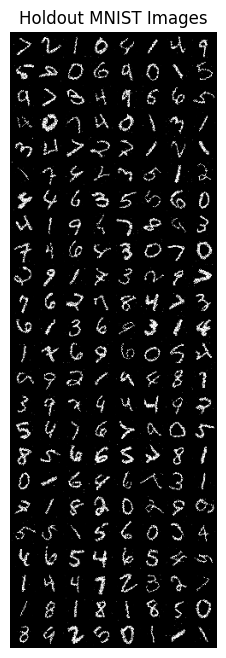

In [2]:
def data_generation(train_share, val_share, batch_size, seed,
                    ood_noise=False):

    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # Define the standard transform: convert to tensor and normalize
    standard_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])

    # Define an OOD transform for the holdout set if requested.
    if ood_noise:
      noise_std = 0.2
      holdout_transform = transforms.Compose([
          transforms.RandomRotation(45),          # Rotate PIL image
          transforms.ToTensor(),                    # Convert to tensor
          transforms.Lambda(lambda x: x + torch.randn_like(x) * noise_std),  # Add noise
          transforms.Normalize((0.5,), (0.5,))
          ])
    else:
      holdout_transform = transforms.Compose([
            transforms.RandomRotation(45),  # rotate images randomly up to 45 degrees
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])


    data_dir='~/.pytorch/MNIST_data/'
    # Load the full training dataset (60,000 images)
    full_dataset = datasets.MNIST(data_dir, download=True, train=True, transform=standard_transform)

    # Load the holdout dataset - test dataset (10,000 images)
    holdout_dataset = datasets.MNIST(data_dir, download=True, train=False, transform=holdout_transform)

    # Compute dataset sizes for splitting the full training set
    full_len = len(full_dataset)
    train_len = int(train_share * full_len)
    val_len = int(val_share * full_len)
    test_len = full_len - train_len - val_len

    # Randomly split the full dataset into train, validation, and test sets
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Create DataLoaders for training, validation, and test sets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Create DataLoader for the holdout (official test) set
    holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

    # Optionally, print the sizes of the splits
    print("Train set size:", len(train_set))
    print("Validation set size:", len(val_set))
    print("Test set size:", len(test_set))

    return train_loader, val_loader, test_loader, holdout_loader

# test the function
train_share = 0.2
val_share = 0.2
batch_size = 64*3
data_seed = 42

train_loader, val_loader, test_loader, holdout_loader = data_generation(train_share, val_share, batch_size, data_seed,
                                                                        ood_noise=True)



# PLOT
dataiter = iter(holdout_loader)
images, labels = next(dataiter)

# Create a grid of images
img_grid = torchvision.utils.make_grid(images)

# For MNIST (grayscale), adjust dimensions and display
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title("Holdout MNIST Images")
plt.axis("off")
plt.show()

### Load models

In [3]:
import sys
# locally
#sys.path.append('../src')

# for colab
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Thesis_REMOVE/

# Append your folder's path to sys.path
sys.path.append('/content/drive/MyDrive/Thesis_REMOVE/')

from members import CnnNet
from deep_ensemble import DeepEnsemble
from calibrator import Calibrator

from plotting import plot_metrics, plot_confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
calibrator.py  deep_ensemble.py  members.py  plotting.py


Early stopping triggered at epoch 14.


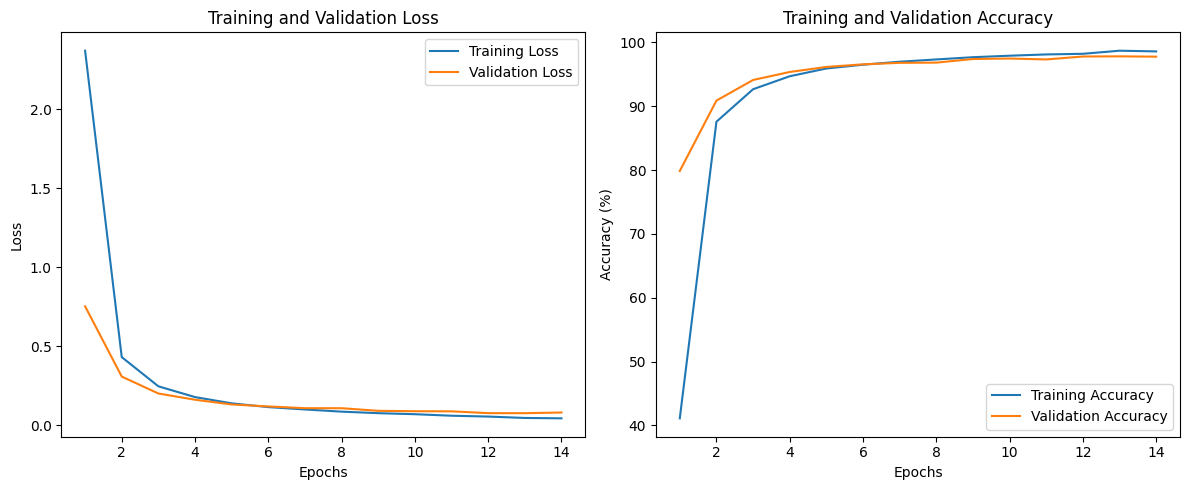

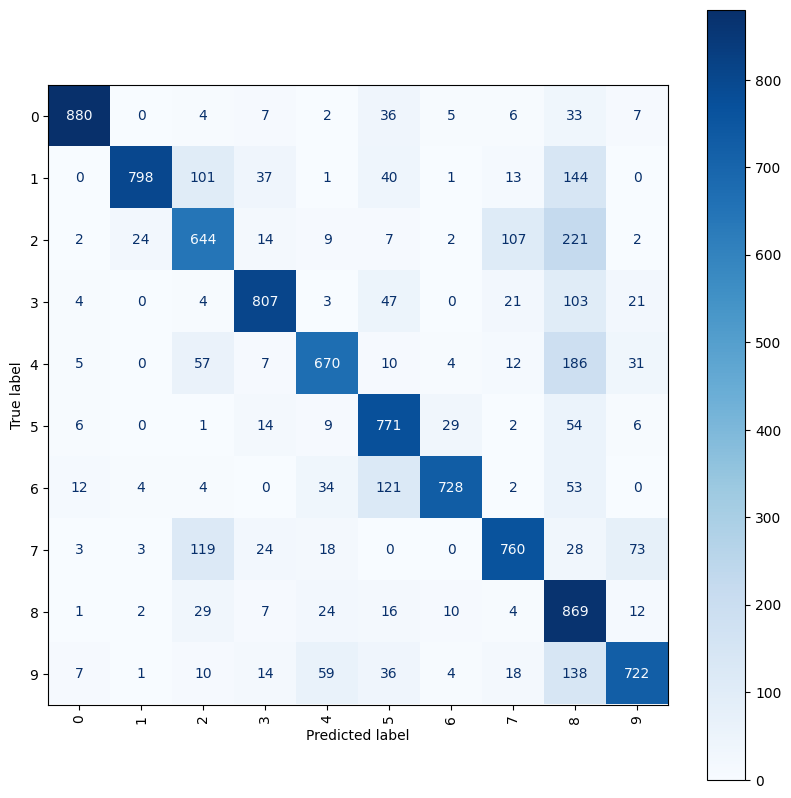

In [4]:
input_shape = 28*28
output_shape = 10

lr = 1e-3
criterion = nn.CrossEntropyLoss()
num_epochs = 30
patience = 3
min_delta = 1e-6

cnn = CnnNet(input_shape, output_shape)
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = cnn.train_model(train_loader, val_loader, criterion, optimizer,
                                                                             num_epochs, patience, min_delta)

# Plot the training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, len(val_losses))

# Evluating the model
class_names = [str(i) for i in range(10)]
#plot_confusion_matrix(cnn, test_loader, class_names)
plot_confusion_matrix(cnn, holdout_loader, class_names)

DeepEnsemble(
  (models): ModuleList(
    (0-4): 5 x CnnNet(
      (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=384, out_features=120, bias=True)
      (fc2): Linear(in_features=120, out_features=10, bias=True)
    )
  )
)
Early stopping triggered for model 1 at epoch 16.
Early stopping triggered for model 0 at epoch 19.
Early stopping triggered for model 2 at epoch 20.
Early stopping triggered for model 4 at epoch 20.
Early stopping triggered for model 3 at epoch 21.
All models have stopped. Ending training at epoch 21.


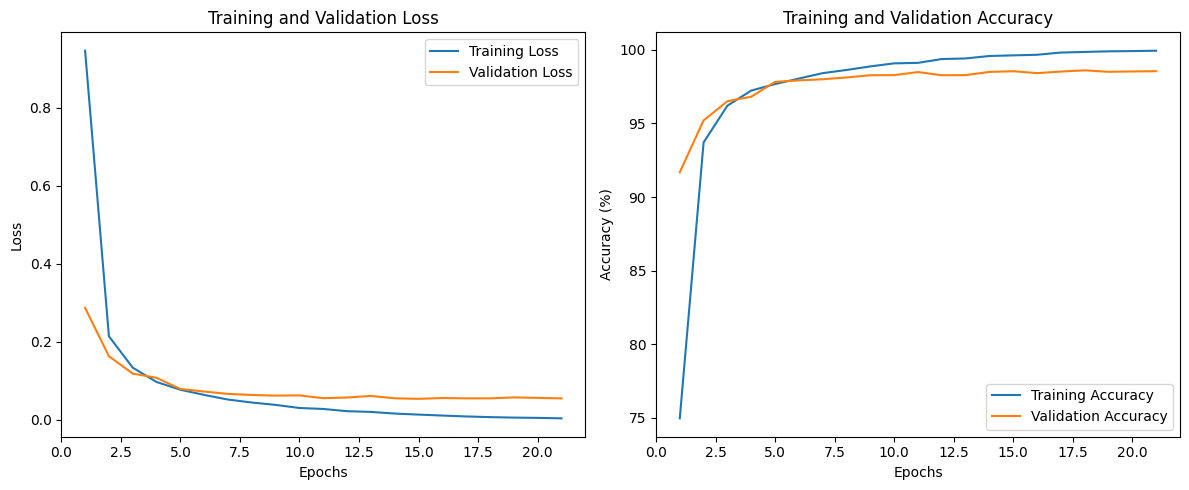

Validation accuracy:  98.55


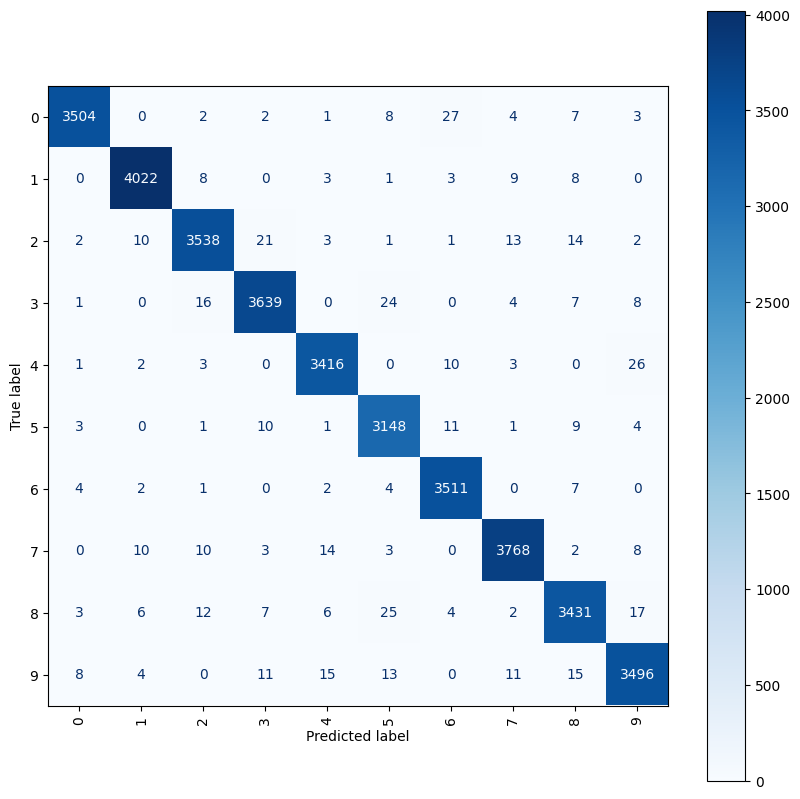

In [5]:
epsilon = 0.1
weight_decay = 1e-5

#instnatiate the deep ensemble
ensemble_model = DeepEnsemble( num_models=5, model_class=CnnNet, lr=lr, weight_decay=weight_decay,
                             output_shape=10, input_shape=None  # Passed as keyword argument to SimpleClassifier
                             )
print(ensemble_model)

de_train_results = ensemble_model.train_model(train_loader, val_loader, criterion, num_epochs, epsilon, adversarial_training=False,    # NOTE false
                                        patience=5, min_delta=1e-6)
#plot the results
plot_metrics(de_train_results['train_losses'], de_train_results['val_losses'],
             de_train_results['train_accuracies'],  de_train_results['val_accuracies'], len(de_train_results['train_losses']))
print("Validation accuracy: ", de_train_results['val_accuracies'][-1])
plot_confusion_matrix(ensemble_model, test_loader, class_names=class_names)

# Pipeline

### Check to make sure grid is accurate

1. With early stopping
2. Without early stopping

### Early stopping

In [6]:
num_seeds = 2

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_share}_{val_share}_{(1-(train_share+val_share))}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = CnnNet(input_shape, output_shape)
    optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)
    cnn_holdout = cnn_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll']),
        "NLL Holdout": np.mean(cnn_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=CnnNet, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)


df_mean = df_results_no_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean


=== Running experiment with MODEL SEED = 25 ===
Early stopping triggered at epoch 21.
Early stopping triggered for model 2 at epoch 13.
Early stopping triggered for model 1 at epoch 16.
Early stopping triggered for model 0 at epoch 18.
Early stopping triggered for model 4 at epoch 18.
Early stopping triggered for model 3 at epoch 22.
All models have stopped. Ending training at epoch 22.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.0909090909090908, 'c2': 1.0, 'epi_scalar': 1, 'nll_val': 0.050931695848703384}
Calibrating using method: convex_comb
Best parameters: {'c1': 1.018181818181818, 'c2': 0.05050505050505051, 'epi_scalar': 1, 'nll_val': 0.04942842200398445}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 1.018181818181818, 'c2': 0.06060606060606061, 'epi_scalar': 1, 'nll_val': 0.0494348481297493}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 1.018181818181818, 'c2': 0.09090909090909091, 'epi_scalar': 1, 'nll_val': 0.0

,NLL Val,NLL Test,NLL Holdout,C1,C2,Epi Scalar,Epsilon
Model,,,,,,,
Calibrator_convex_comb_global,0.054582,0.056725,0.789647,0.990909,0.065657,1.0,0.0
Calibrator_convex_comb,0.054572,0.056739,0.788083,0.990909,0.035354,1.0,0.0
Calibrator_convex_comb_no_exp,0.054575,0.056759,0.769796,0.990909,0.045455,1.0,0.0
DeepEnsemble,0.055915,0.056973,0.827443,NaN,NaN,NaN,0.0
Calibrator_pure_logits,0.055797,0.057036,0.804008,1.045455,1.000000,1.0,0.0
Simple NN,0.066472,0.068487,0.854543,NaN,NaN,NaN,NaN


In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_share}_{val_share}_{(1-(train_share+val_share))}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = CnnNet(input_shape, output_shape)
    optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)
    cnn_holdout = cnn_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll']),
        "NLL Holdout": np.mean(cnn_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=CnnNet, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE true
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_AT = pd.DataFrame(results_list)


df_mean = df_results_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

### Without early stopping

#### Set the right num_epochs

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
num_epochs = 25
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_share}_{val_share}_{(1-(train_share+val_share))}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = CnnNet(input_shape, output_shape)
    optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)
    cnn_holdout = cnn_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll']),
        "NLL Holdout": np.mean(cnn_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=CnnNet, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=False,
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_no_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_no_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
num_epochs = 25
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_share}_{val_share}_{(1-(train_share+val_share))}_{batch_size}_OOD_with_noise",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = CnnNet(input_shape, output_shape)
    optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,                                                 # NOTE False
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)
    cnn_holdout = cnn_member.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll']),
        "NLL Holdout": np.mean(cnn_holdout['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=CnnNet, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE true
                                  early_stopping=False,                             # NOTE False
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)
    ensemble_holdout = deep_ensemble.predict(holdout_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll']),
        "NLL Holdout": np.mean(ensemble_holdout['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_holdout = calibrator.predict(holdout_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"]),
            "NLL Holdout": np.mean(calib_holdout["nll"])
        })



# NOTE naming based of data
df_results_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'NLL Holdout', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

### Save most promising result

In [ ]:
#save results
from google.colab import files
df_results_no_AT.to_csv('MNIST_results_AT_noES_25_35.csv', index=False)
files.download('MNIST_results_AT_noES_25_35.csv')